# Перемешиваем модальности

# Metadata
transforms, model+optimizer+loss, hyperparams

In [1]:
TITLE = "int+flip, SegResNetDS+adanrandom+dicefocal"

# Imports

In [2]:
from glio.imports import *
from glio.importsglio import *

from glio.datasets.mri_preloaded import *
from glio.specific.mri_around import *
from glio.specific.vkr import *
from glio.transforms.intensity import RandScale, RandShift
from glio.transforms.spatial import RandFlipt

from glio.torch_tools import ConcatZeroChannelsToDataloader, BatchInputTransforms

d:\miniconda3\envs\pytorch311\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


# Dataset

In [3]:
rhuhtrain = get_ds_around(RHUH_NOHIST140_NOADC_TRAIN) + get_ds_around(RHUH_NOHIST140_NOADC_TEST)
bratstest = get_ds_around(BRATS2024SMALL_NOHIST96_TEST)

In [4]:

from monai import transforms as mtf

# fast tfms
gaussianblur = mtf.RandGaussianSmooth(prob=0.1) # type:ignore
contrast = mtf.RandAdjustContrast(gamma = (0.5, 2), prob=0.1) # type:ignore

# slower tfms
biasfield = mtf.RandBiasField(prob=0.1) # type:ignore
hist_shift = mtf.RandHistogramShift(prob=0.05) # type:ignore
gibbs = mtf.RandGibbsNoise(prob=0.1) # type:ignore
riccan = mtf.RandRicianNoise(std=0.5, prob=0.05) # type:ignore

# very slow
kspike = mtf.RandKSpaceSpikeNoise(prob=0.1) # type:ignore

def rand_shuffle_channels_around(x:torch.Tensor, channels_per = 3):
    if random.random() < 0.1:
        num_groups = int(x.shape[0] / channels_per)
        perm = torch.randperm(num_groups, dtype=torch.int32)
        img= x.reshape(num_groups, channels_per, *x.shape[1:])[perm].flatten(0, 1)
        return img
    return x

def rand_group_dropout(x):
    if random.random() < 0.05: return torch.zeros_like(x)
    if random.random() < 0.05: return torch.randn_like(x)
    return x

def randnoise(x):
    if random.random() < 0.1: return x + torch.randn_like(x) * random.triangular(0, 0.5, 0)
    return x


In [5]:
dstrain = DSToTarget(0)
dstest = DSToTarget(0)

dstrain.add_samples(rhuhtrain, loader_around_seq, [randcrop, RandFlipt(p=0.5)], [get0, rand_shuffle_channels_around, GroupwiseTfms((randnoise, RandScale(p=0.3), RandShift(p=0.3), rand_group_dropout))], get1)
dstest.add_samples(bratstest, loader_around_seq, randcrop, get0, get1)
print(len(dstrain))
print(len(dstest))

20893
3437


# Performance

In [6]:
x = torch.randn((3,96,96))
with perf_counter_context():
    for i in range(100):
        dstrain[i]

Context took 0.8621819000691175 perf_counter seconds


# Inputs / targets preview

(<Figure size 2400x2400 with 4 Axes>,
 array([[<Axes: title={'center': 'inputs'}>,
         <Axes: title={'center': 'targets'}>],
        [<Axes: title={'center': 'inputs - test'}>,
         <Axes: title={'center': 'targets - test'}>]], dtype=object))

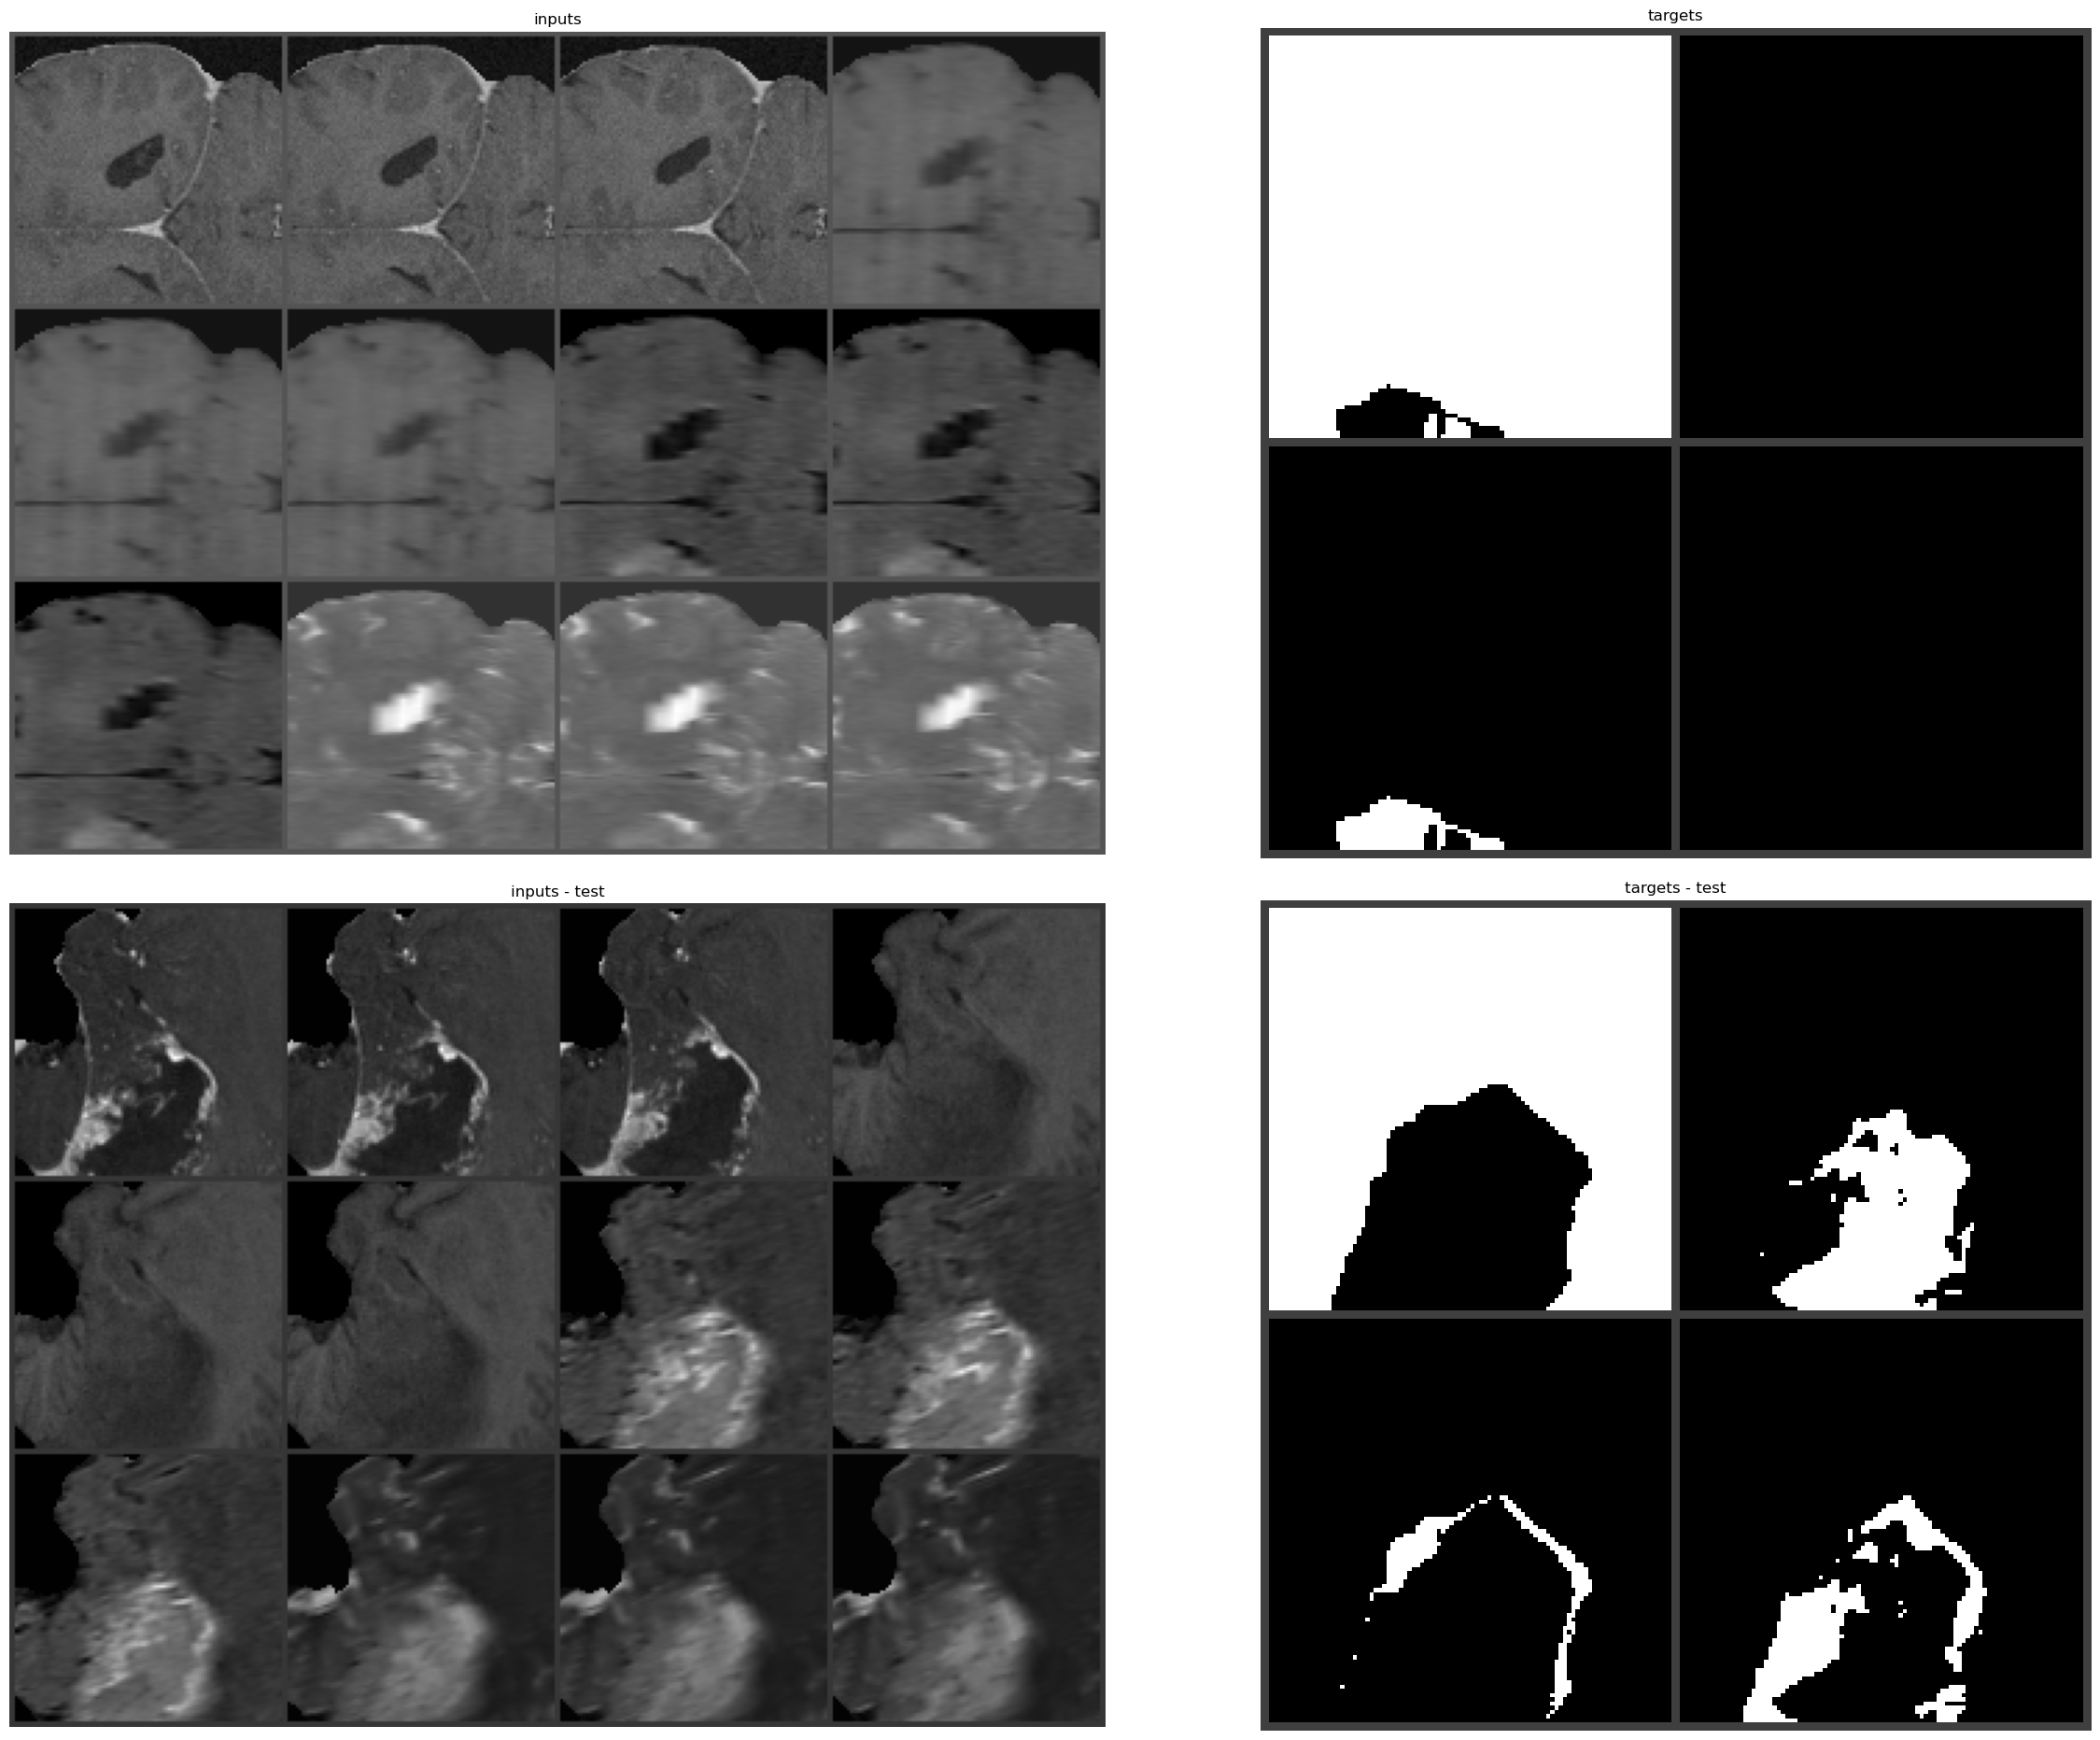

In [7]:
fig = Figure()
sample_ = dstrain[300]
fig.add().imshow_batch(sample_[0]).style_img('inputs')
fig.add().imshow_batch(sample_[1]).style_img('targets')
sample_ = dstest[20]
fig.add().imshow_batch(sample_[0]).style_img('inputs - test')
fig.add().imshow_batch(sample_[1]).style_img('targets - test')
fig.create(2, figsize=(24,24))

# Model

In [8]:
from monai.networks.nets import SegResNetDS # type:ignore
print(f"{count_parameters(SegResNetDS(2, 32, 12, 4)) = }")

count_parameters(SegResNetDS(2, 32, 12, 4)) = 6645764


# Train

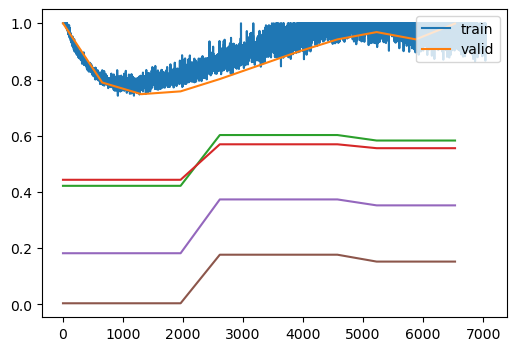

Keyboard interrupt, stopping the training...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
test loss: min: 0.7479; max: 1.0210; last: 0.9991
test iou: min: 0.4691; max: 0.9209; last: 0.8101
test average precision: min: 0.2434; max: 0.2688; last: 0.2668
test roc auc: min: 0.4615; max: 0.5653; last: 0.5529
test sensitivity: min: 0.

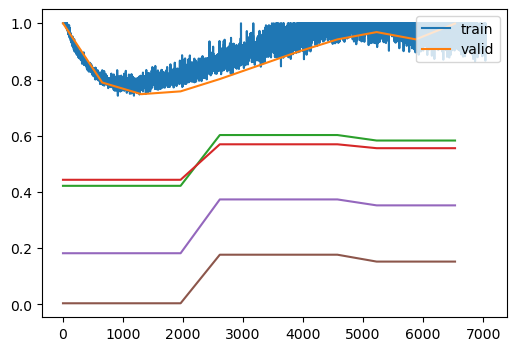

In [11]:
from stuff.found.torch.optim.Adan import Adan
from torchzero.optim import RandomGrad
from monai.losses import DiceFocalLoss # type:ignore

MODEL = SegResNetDS(2, 32, 12, 4)
NAME = f"{MODEL.__class__.__name__}"
LR = 2e-3
BATCH_SIZE = 32
N_EPOCHS = 150

# dl_train = DataLoader(ds_train, BATCH_SIZE)
dltrain = DataLoader(dstrain, BATCH_SIZE, shuffle=True)
dltest = DataLoader(dstest, BATCH_SIZE)

OPT = RandomGrad(MODEL.parameters(), opt=Adan(MODEL.parameters(), lr=LR))
LOSS_FN = DiceFocalLoss(softmax=True)
#SCHED = lr_scheduler.OneCycleLR(OPT, max_lr=LR, steps_per_epoch=len(dltrain), epochs=N_EPOCHS)
SCHED = None

clean_mem()
# MODEL = gnn.LSUV(MODEL, dltrain, max_iter=10)

CALLBACKS =  (Metric_Loss(),
              Log_Time(), Save_Best(), Save_Last(), PerformanceTweaks(True), Accelerate("no"),
              #Log_LR(), 
              MONAI_IoU(4, True, True, step=32, name='iou'),
              Torcheval_AURPC(4, True, step=32),
              Torcheval_AUROC(4, True, step=32),
              MONAI_ConfusionMatrix(step=4), MONAI_ConfusionMatrixMetrics(),
              MONAI_ConfusionMatrix(step=4, include_bg = False, name="nobg confusion matrix"), MONAI_ConfusionMatrixMetrics(key = 'nobg confusion matrix', prefix='nobg '),
              FastProgressBar(step_batch=128, plot=True, metrics=('train loss', 'test loss', 
                                                                  'test balanced accuracy', 'test nobg balanced accuracy',
                                                                  'test f1 score', 'test nobg f1 score'), maxv=1),
              Summary(),
              PlotSummary(path='summaries'),
              PrintLoss(),
              SaveReferenceVisualizationsAfterEachEpoch('reference preds'),
              #Metric_PredsTargetsFn(LOSS_FN, name='dice loss'),
              #CallTrainAndEvalOnOptimizer(),
              #AddLossReturnedByModelToLossInBackward(),
              OneBatch_ClosureWithNoBackward(),
              GradientFreeWithZeroGrad(),
            )

LEARNER_NAME = f"{TITLE} lr{LR:.0e} magn1e-5"
learner = Learner(MODEL, LEARNER_NAME,
                  cbs = CALLBACKS,
                  loss_fn=LOSS_FN,
                  optimizer=OPT,
                  scheduler=SCHED,)
learner.fit(N_EPOCHS, dltrain, dltest, test_first=True, test_on_interrupt=False)
plt.show()
